In [1]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
#读取数据
class DataGen(keras.utils.Sequence):  
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size#一次训练样本数
        self.image_size = image_size#图片大小
        self.on_epoch_end()
        
    def __load__(self, id_name):
        #文件路径
        image_path = os.path.join(self.path, "images", id_name) + ".jpg"#原图
        mask_path = os.path.join(self.path, "masks", id_name) + "_segmentation.png"#分割图
        
        #分别读原图、正确分割的图
        image = cv2.imread(image_path,1)#加载彩色图片
        image = cv2.resize(image, (self.image_size, self.image_size))#调整大小
        mask = np.zeros((self.image_size, self.image_size, 1))#128*128*1
        _mask = cv2.imread(mask_path, -1)#cv2.IMREAD_UNCHANGED
        _mask = cv2.resize(_mask, (self.image_size, self.image_size))#调整大小
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)#选择最大值
        
        #图像进行归一化，范围为[0, 1]
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask   #返回数组
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
image_size = 128
path = "./datasets/ISIC2018/"#训练集路径
train_path = "./datasets/ISIC2018/images"
batch_size = 20   #一次训练样本数

train_ids = []
for files in os.walk(train_path):#遍历目录
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]#获得文件名
train_ids = [i.split('.', 1)[0] for i in train_ids]#去.jpg后缀

val_data_size = 30#验证集大小

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]#数据分为2部分

In [4]:
gen = DataGen(train_ids, path, batch_size=batch_size, image_size=image_size)#读取训练用的图片

x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(20, 128, 128, 3) (20, 128, 128, 1)


14


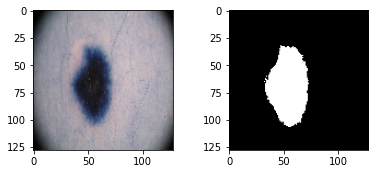

In [5]:
#验证是否成功读取图片
r = random.randint(0, len(x)-1)#图片数量范围内的随机数
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)#调整页面布局
ax = fig.add_subplot(1, 2, 1)#第1图
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)#第2图
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [6]:
#模型设计
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [7]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3]) 
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

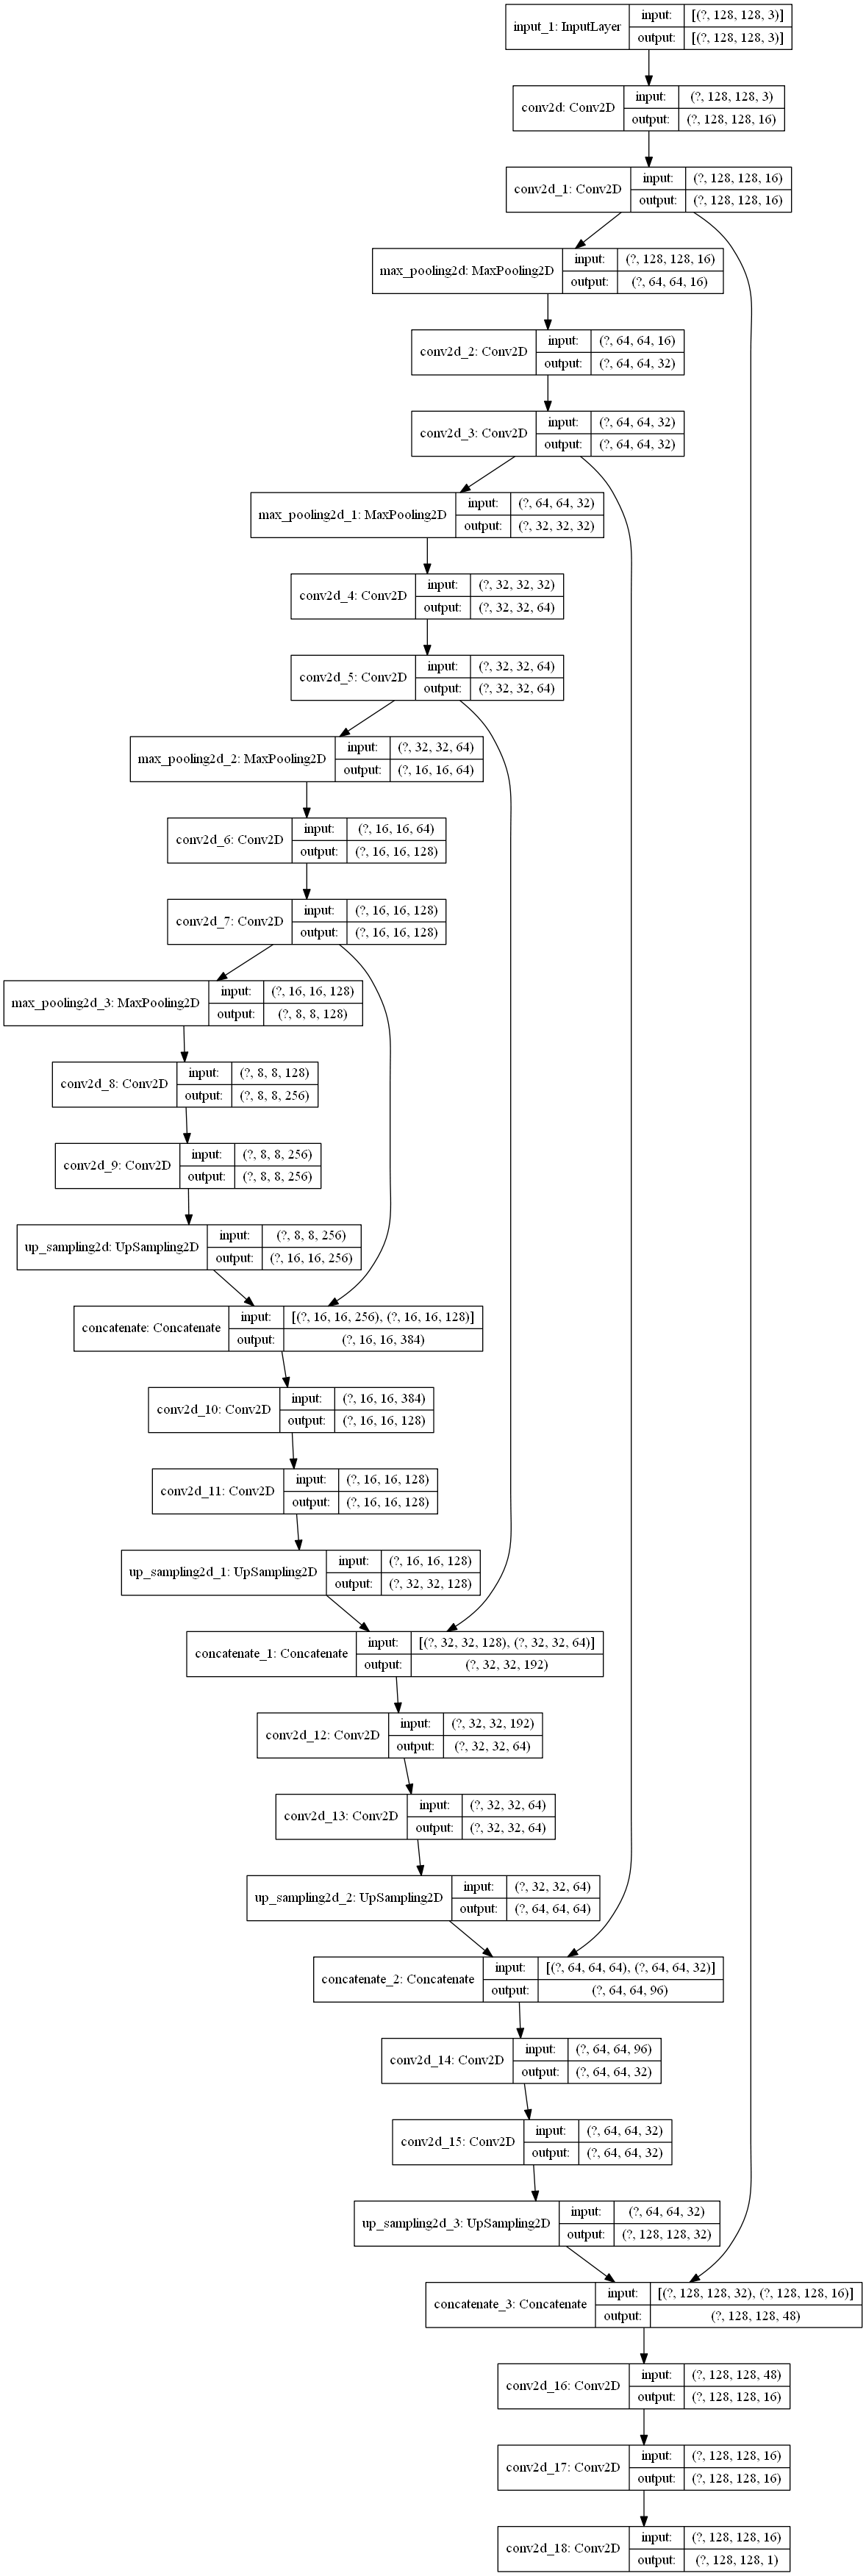

In [8]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])#优化器，损失函数，评估标准
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
train_gen = DataGen(train_ids, path)
valid_gen = DataGen(valid_ids, path,3,128)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

#按批次训练模型
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs = 10)
model.save("U-Net_Model.h5")#保存模型

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 1 steps
Epoch 1/10
12/12 [==============================] - 14s 1s/step - loss: 0.6317 - acc: 0.6414 - val_loss: 0.4511 - val_acc: 0.7059
Epoch 2/10
12/12 [==============================] - 14s 1s/step - loss: 0.5279 - acc: 0.6906 - val_loss: 0.3021 - val_acc: 0.9222
Epoch 3/10
12/12 [==============================] - 15s 1s/step - loss: 0.5697 - acc: 0.7746 - val_loss: 0.3628 - val_acc: 0.8488
Epoch 4/10
12/12 [==============================] - 15s 1s/step - loss: 0.4623 - acc: 0.8185 - val_loss: 0.3228 - val_acc: 0.8534
Epoch 5/10
12/12 [==============================] - 15s 1s/step - loss: 0.4262 - acc: 0.8286 - val_loss: 0.2360 - val_acc: 0.9284
Epoch 6/10
12/12 [==============================] - 15s 1s/step - loss: 0.3470 - acc: 0.8620 - val_loss: 0.1805 - val_acc: 0.9224
Epoch 7/10
12/12 [==============================] - 1

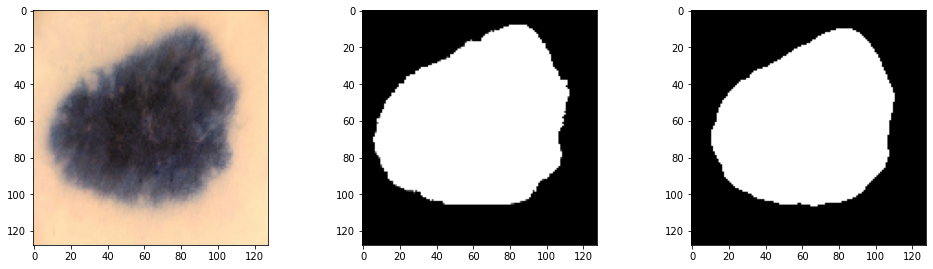

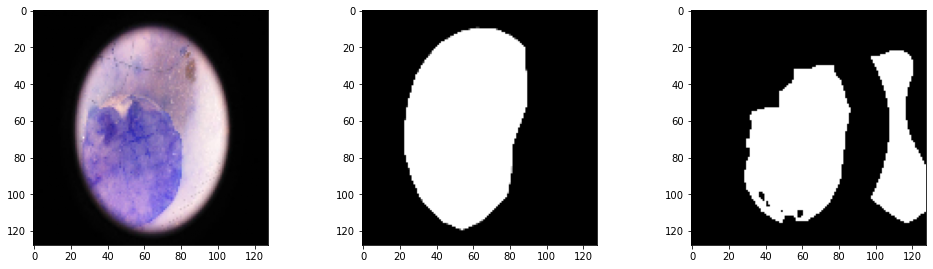

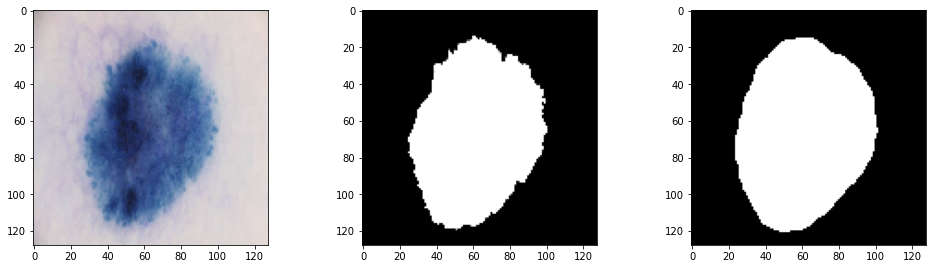

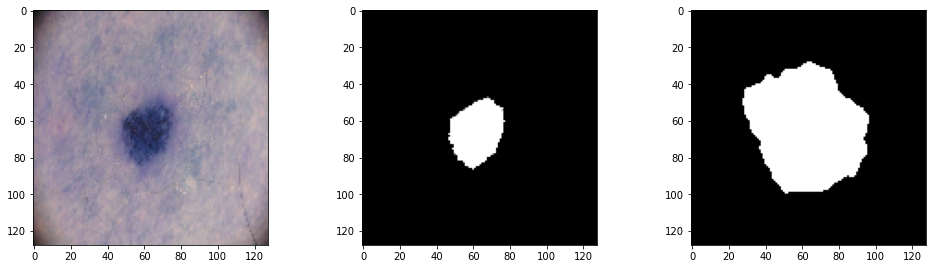

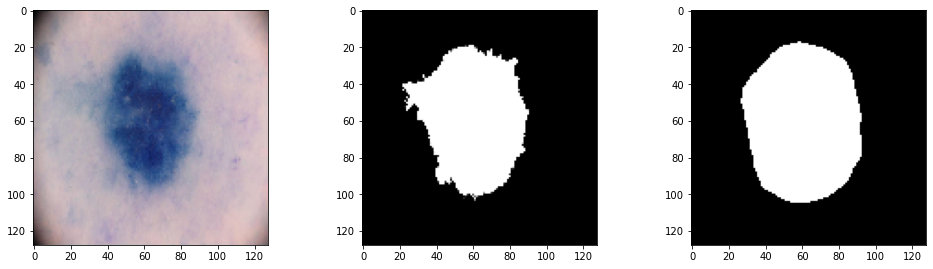

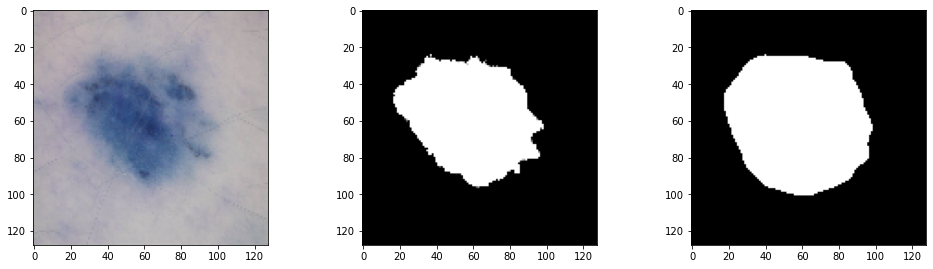

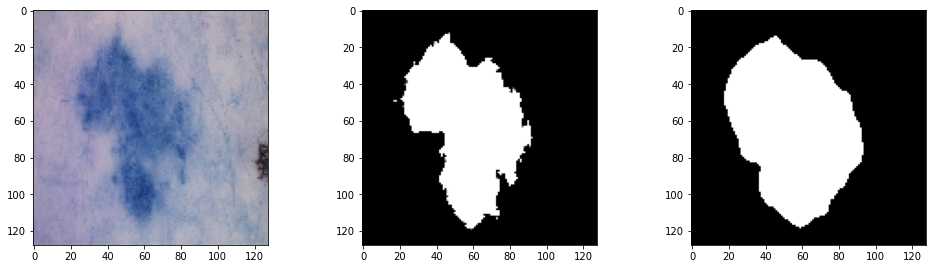

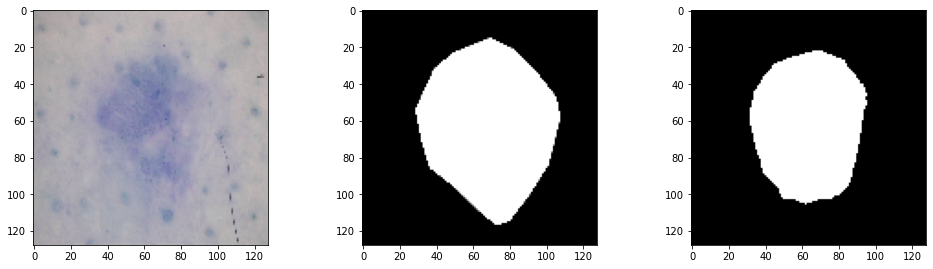

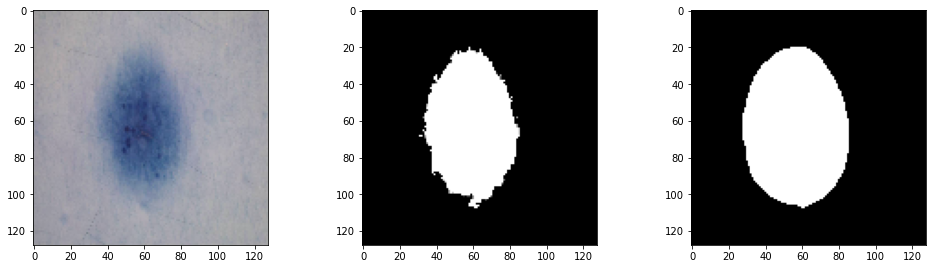

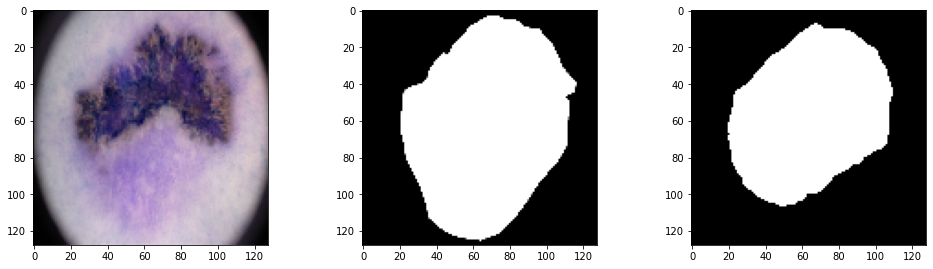

In [10]:
for i in range(0,10):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils import compute_class_weight as sk_compute_class_weight


def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard, thresholded_jaccard

print(compute_jaccard(y, result))

(0.4050936035947152, 0.2704544695626802)
